In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right']])
X_train = np.asarray(tr_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                        "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(ts_df[['rt', 'Right']])
X_test = np.asarray(ts_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                        "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(6804, 8) (2927, 8)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2000)

Epoch 1/2000
1/1 [==============================] - 193s 193s/step - loss: 31905.3691
Epoch 2/2000
1/1 [==============================] - 0s 57ms/step - loss: 31767.0938
Epoch 3/2000
1/1 [==============================] - 0s 54ms/step - loss: 31667.3965
Epoch 4/2000
1/1 [==============================] - 0s 44ms/step - loss: 31584.4531
Epoch 5/2000
1/1 [==============================] - 0s 40ms/step - loss: 31511.3320
Epoch 6/2000
1/1 [==============================] - 0s 42ms/step - loss: 31444.8164
Epoch 7/2000
1/1 [==============================] - 0s 44ms/step - loss: 31383.0977
Epoch 8/2000
1/1 [==============================] - 0s 45ms/step - loss: 31325.0645
Epoch 9/2000
1/1 [==============================] - 0s 42ms/step - loss: 31269.9570
Epoch 10/2000
1/1 [==============================] - 0s 41ms/step - loss: 31217.2363
Epoch 11/2000
1/1 [==============================] - 0s 41ms/step - loss: 31166.5176
Epoch 12/2000
1/1 [==============================] - 0s 42ms/step - loss

1/1 [==============================] - 0s 62ms/step - loss: 28492.1641
Epoch 98/2000
1/1 [==============================] - 0s 61ms/step - loss: 28469.4883
Epoch 99/2000
1/1 [==============================] - 0s 61ms/step - loss: 28446.9316
Epoch 100/2000
1/1 [==============================] - 0s 62ms/step - loss: 28424.5000
Epoch 101/2000
1/1 [==============================] - 0s 62ms/step - loss: 28402.1914
Epoch 102/2000
1/1 [==============================] - 0s 61ms/step - loss: 28380.0000
Epoch 103/2000
1/1 [==============================] - 0s 61ms/step - loss: 28357.9258
Epoch 104/2000
1/1 [==============================] - 0s 61ms/step - loss: 28335.9727
Epoch 105/2000
1/1 [==============================] - 0s 60ms/step - loss: 28314.1328
Epoch 106/2000
1/1 [==============================] - 0s 61ms/step - loss: 28292.4062
Epoch 107/2000
1/1 [==============================] - 0s 59ms/step - loss: 28270.7969
Epoch 108/2000
1/1 [==============================] - 0s 61ms/step - lo

1/1 [==============================] - 0s 62ms/step - loss: 26756.0000
Epoch 193/2000
1/1 [==============================] - 0s 64ms/step - loss: 26741.0293
Epoch 194/2000
1/1 [==============================] - 0s 63ms/step - loss: 26726.1113
Epoch 195/2000
1/1 [==============================] - 0s 61ms/step - loss: 26711.2324
Epoch 196/2000
1/1 [==============================] - 0s 60ms/step - loss: 26696.4043
Epoch 197/2000
1/1 [==============================] - 0s 64ms/step - loss: 26681.6172
Epoch 198/2000
1/1 [==============================] - 0s 63ms/step - loss: 26666.8809
Epoch 199/2000
1/1 [==============================] - 0s 64ms/step - loss: 26652.1797
Epoch 200/2000
1/1 [==============================] - 0s 63ms/step - loss: 26637.5293
Epoch 201/2000
1/1 [==============================] - 0s 61ms/step - loss: 26622.9121
Epoch 202/2000
1/1 [==============================] - 0s 59ms/step - loss: 26608.3359
Epoch 203/2000
1/1 [==============================] - 0s 61ms/step - 

1/1 [==============================] - 0s 62ms/step - loss: 25443.4219
Epoch 288/2000
1/1 [==============================] - 0s 60ms/step - loss: 25430.1406
Epoch 289/2000
1/1 [==============================] - 0s 61ms/step - loss: 25416.8691
Epoch 290/2000
1/1 [==============================] - 0s 60ms/step - loss: 25403.6035
Epoch 291/2000
1/1 [==============================] - 0s 60ms/step - loss: 25390.3477
Epoch 292/2000
1/1 [==============================] - 0s 62ms/step - loss: 25377.0938
Epoch 293/2000
1/1 [==============================] - 0s 63ms/step - loss: 25363.8516
Epoch 294/2000
1/1 [==============================] - 0s 60ms/step - loss: 25350.6133
Epoch 295/2000
1/1 [==============================] - 0s 61ms/step - loss: 25337.3867
Epoch 296/2000
1/1 [==============================] - 0s 65ms/step - loss: 25324.1582
Epoch 297/2000
1/1 [==============================] - 0s 63ms/step - loss: 25310.9434
Epoch 298/2000
1/1 [==============================] - 0s 63ms/step - 

1/1 [==============================] - 0s 61ms/step - loss: 23791.1484
Epoch 383/2000
1/1 [==============================] - 0s 60ms/step - loss: 23767.8516
Epoch 384/2000
1/1 [==============================] - 0s 60ms/step - loss: 23744.6152
Epoch 385/2000
1/1 [==============================] - 0s 60ms/step - loss: 23721.4512
Epoch 386/2000
1/1 [==============================] - 0s 61ms/step - loss: 23698.3496
Epoch 387/2000
1/1 [==============================] - 0s 60ms/step - loss: 23675.3125
Epoch 388/2000
1/1 [==============================] - 0s 61ms/step - loss: 23652.3457
Epoch 389/2000
1/1 [==============================] - 0s 60ms/step - loss: 23629.4453
Epoch 390/2000
1/1 [==============================] - 0s 60ms/step - loss: 23606.6094
Epoch 391/2000
1/1 [==============================] - 0s 60ms/step - loss: 23583.8457
Epoch 392/2000
1/1 [==============================] - 0s 60ms/step - loss: 23561.1523
Epoch 393/2000
1/1 [==============================] - 0s 61ms/step - 

1/1 [==============================] - 0s 60ms/step - loss: 21862.8906
Epoch 478/2000
1/1 [==============================] - 0s 63ms/step - loss: 21844.7539
Epoch 479/2000
1/1 [==============================] - 0s 60ms/step - loss: 21826.6484
Epoch 480/2000
1/1 [==============================] - 0s 60ms/step - loss: 21808.5547
Epoch 481/2000
1/1 [==============================] - 0s 60ms/step - loss: 21790.4922
Epoch 482/2000
1/1 [==============================] - 0s 60ms/step - loss: 21772.4336
Epoch 483/2000
1/1 [==============================] - 0s 60ms/step - loss: 21754.4023
Epoch 484/2000
1/1 [==============================] - 0s 60ms/step - loss: 21736.3770
Epoch 485/2000
1/1 [==============================] - 0s 61ms/step - loss: 21718.3730
Epoch 486/2000
1/1 [==============================] - 0s 61ms/step - loss: 21700.3652
Epoch 487/2000
1/1 [==============================] - 0s 61ms/step - loss: 21682.3730
Epoch 488/2000
1/1 [==============================] - 0s 60ms/step - 

1/1 [==============================] - 0s 60ms/step - loss: 20151.8516
Epoch 573/2000
1/1 [==============================] - 0s 60ms/step - loss: 20134.0449
Epoch 574/2000
1/1 [==============================] - 0s 61ms/step - loss: 20116.1641
Epoch 575/2000
1/1 [==============================] - 0s 60ms/step - loss: 20098.4023
Epoch 576/2000
1/1 [==============================] - 0s 61ms/step - loss: 20080.5645
Epoch 577/2000
1/1 [==============================] - 0s 61ms/step - loss: 20062.8516
Epoch 578/2000
1/1 [==============================] - 0s 61ms/step - loss: 20045.0586
Epoch 579/2000
1/1 [==============================] - 0s 60ms/step - loss: 20027.3984
Epoch 580/2000
1/1 [==============================] - 0s 60ms/step - loss: 20009.6562
Epoch 581/2000
1/1 [==============================] - 0s 61ms/step - loss: 19992.0547
Epoch 582/2000
1/1 [==============================] - 0s 60ms/step - loss: 19974.3672
Epoch 583/2000
1/1 [==============================] - 0s 59ms/step - 

1/1 [==============================] - 0s 61ms/step - loss: 18640.7910
Epoch 668/2000
1/1 [==============================] - 0s 59ms/step - loss: 18627.0801
Epoch 669/2000
1/1 [==============================] - 0s 61ms/step - loss: 18613.7637
Epoch 670/2000
1/1 [==============================] - 0s 61ms/step - loss: 18600.1406
Epoch 671/2000
1/1 [==============================] - 0s 61ms/step - loss: 18586.9180
Epoch 672/2000
1/1 [==============================] - 0s 60ms/step - loss: 18573.3828
Epoch 673/2000
1/1 [==============================] - 0s 62ms/step - loss: 18560.2539
Epoch 674/2000
1/1 [==============================] - 0s 60ms/step - loss: 18546.8086
Epoch 675/2000
1/1 [==============================] - 0s 59ms/step - loss: 18533.7656
Epoch 676/2000
1/1 [==============================] - 0s 61ms/step - loss: 18520.4043
Epoch 677/2000
1/1 [==============================] - 0s 61ms/step - loss: 18507.4570
Epoch 678/2000
1/1 [==============================] - 0s 60ms/step - 

1/1 [==============================] - 0s 61ms/step - loss: 17528.3789
Epoch 763/2000
1/1 [==============================] - 0s 60ms/step - loss: 17518.6016
Epoch 764/2000
1/1 [==============================] - 0s 62ms/step - loss: 17508.2695
Epoch 765/2000
1/1 [==============================] - 0s 61ms/step - loss: 17498.5547
Epoch 766/2000
1/1 [==============================] - 0s 61ms/step - loss: 17488.2773
Epoch 767/2000
1/1 [==============================] - 0s 61ms/step - loss: 17478.6270
Epoch 768/2000
1/1 [==============================] - 0s 61ms/step - loss: 17468.4102
Epoch 769/2000
1/1 [==============================] - 0s 60ms/step - loss: 17458.8203
Epoch 770/2000
1/1 [==============================] - 0s 61ms/step - loss: 17448.6621
Epoch 771/2000
1/1 [==============================] - 0s 84ms/step - loss: 17439.1328
Epoch 772/2000
1/1 [==============================] - 0s 67ms/step - loss: 17429.0332
Epoch 773/2000
1/1 [==============================] - 0s 64ms/step - 

1/1 [==============================] - 0s 60ms/step - loss: 16693.5645
Epoch 858/2000
1/1 [==============================] - 0s 64ms/step - loss: 16685.5117
Epoch 859/2000
1/1 [==============================] - 0s 64ms/step - loss: 16678.2461
Epoch 860/2000
1/1 [==============================] - 0s 63ms/step - loss: 16670.2305
Epoch 861/2000
1/1 [==============================] - 0s 61ms/step - loss: 16663.0039
Epoch 862/2000
1/1 [==============================] - 0s 62ms/step - loss: 16655.0195
Epoch 863/2000
1/1 [==============================] - 0s 63ms/step - loss: 16647.8301
Epoch 864/2000
1/1 [==============================] - 0s 63ms/step - loss: 16639.8789
Epoch 865/2000
1/1 [==============================] - 0s 64ms/step - loss: 16632.7285
Epoch 866/2000
1/1 [==============================] - 0s 64ms/step - loss: 16624.8125
Epoch 867/2000
1/1 [==============================] - 0s 64ms/step - loss: 16617.6992
Epoch 868/2000
1/1 [==============================] - 0s 62ms/step - 

1/1 [==============================] - 0s 60ms/step - loss: 16035.0928
Epoch 953/2000
1/1 [==============================] - 0s 60ms/step - loss: 16029.3643
Epoch 954/2000
1/1 [==============================] - 0s 61ms/step - loss: 16022.6445
Epoch 955/2000
1/1 [==============================] - 0s 60ms/step - loss: 16016.9453
Epoch 956/2000
1/1 [==============================] - 0s 59ms/step - loss: 16010.2422
Epoch 957/2000
1/1 [==============================] - 0s 60ms/step - loss: 16004.5713
Epoch 958/2000
1/1 [==============================] - 0s 60ms/step - loss: 15997.8984
Epoch 959/2000
1/1 [==============================] - 0s 60ms/step - loss: 15992.2588
Epoch 960/2000
1/1 [==============================] - 0s 61ms/step - loss: 15985.6035
Epoch 961/2000
1/1 [==============================] - 0s 60ms/step - loss: 15980.0020
Epoch 962/2000
1/1 [==============================] - 0s 60ms/step - loss: 15973.3682
Epoch 963/2000
1/1 [==============================] - 0s 61ms/step - 

1/1 [==============================] - 0s 60ms/step - loss: 15505.9668
Epoch 1047/2000
1/1 [==============================] - 0s 60ms/step - loss: 15501.6328
Epoch 1048/2000
1/1 [==============================] - 0s 62ms/step - loss: 15495.8750
Epoch 1049/2000
1/1 [==============================] - 0s 61ms/step - loss: 15491.5615
Epoch 1050/2000
1/1 [==============================] - 0s 59ms/step - loss: 15485.8135
Epoch 1051/2000
1/1 [==============================] - 0s 61ms/step - loss: 15481.5342
Epoch 1052/2000
1/1 [==============================] - 0s 59ms/step - loss: 15475.7988
Epoch 1053/2000
1/1 [==============================] - 0s 60ms/step - loss: 15471.5469
Epoch 1054/2000
1/1 [==============================] - 0s 61ms/step - loss: 15465.8340
Epoch 1055/2000
1/1 [==============================] - 0s 61ms/step - loss: 15461.6064
Epoch 1056/2000
1/1 [==============================] - 0s 60ms/step - loss: 15455.9102
Epoch 1057/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 61ms/step - loss: 15073.5371
Epoch 1141/2000
1/1 [==============================] - 0s 60ms/step - loss: 15070.2744
Epoch 1142/2000
1/1 [==============================] - 0s 61ms/step - loss: 15065.1758
Epoch 1143/2000
1/1 [==============================] - 0s 62ms/step - loss: 15061.9434
Epoch 1144/2000
1/1 [==============================] - 0s 60ms/step - loss: 15056.8652
Epoch 1145/2000
1/1 [==============================] - 0s 60ms/step - loss: 15053.6348
Epoch 1146/2000
1/1 [==============================] - 0s 60ms/step - loss: 15048.5576
Epoch 1147/2000
1/1 [==============================] - 0s 61ms/step - loss: 15045.3682
Epoch 1148/2000
1/1 [==============================] - 0s 61ms/step - loss: 15040.2939
Epoch 1149/2000
1/1 [==============================] - 0s 61ms/step - loss: 15037.0938
Epoch 1150/2000
1/1 [==============================] - 0s 60ms/step - loss: 15032.0273
Epoch 1151/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 62ms/step - loss: 14707.8340
Epoch 1235/2000
1/1 [==============================] - 0s 60ms/step - loss: 14705.3242
Epoch 1236/2000
1/1 [==============================] - 0s 60ms/step - loss: 14700.5459
Epoch 1237/2000
1/1 [==============================] - 0s 61ms/step - loss: 14698.0508
Epoch 1238/2000
1/1 [==============================] - 0s 60ms/step - loss: 14693.1885
Epoch 1239/2000
1/1 [==============================] - 0s 61ms/step - loss: 14690.7227
Epoch 1240/2000
1/1 [==============================] - 0s 60ms/step - loss: 14685.9248
Epoch 1241/2000
1/1 [==============================] - 0s 61ms/step - loss: 14683.4443
Epoch 1242/2000
1/1 [==============================] - 0s 61ms/step - loss: 14678.6172
Epoch 1243/2000
1/1 [==============================] - 0s 60ms/step - loss: 14676.1738
Epoch 1244/2000
1/1 [==============================] - 0s 60ms/step - loss: 14671.3447
Epoch 1245/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 62ms/step - loss: 14373.9170
Epoch 1329/2000
1/1 [==============================] - 0s 62ms/step - loss: 14371.9180
Epoch 1330/2000
1/1 [==============================] - 0s 61ms/step - loss: 14366.9971
Epoch 1331/2000
1/1 [==============================] - 0s 60ms/step - loss: 14365.0430
Epoch 1332/2000
1/1 [==============================] - 0s 60ms/step - loss: 14360.1855
Epoch 1333/2000
1/1 [==============================] - 0s 61ms/step - loss: 14358.2617
Epoch 1334/2000
1/1 [==============================] - 0s 60ms/step - loss: 14353.3125
Epoch 1335/2000
1/1 [==============================] - 0s 61ms/step - loss: 14351.3496
Epoch 1336/2000
1/1 [==============================] - 0s 62ms/step - loss: 14346.4258
Epoch 1337/2000
1/1 [==============================] - 0s 60ms/step - loss: 14344.4326
Epoch 1338/2000
1/1 [==============================] - 0s 61ms/step - loss: 14339.3203
Epoch 1339/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 61ms/step - loss: 14049.9609
Epoch 1423/2000
1/1 [==============================] - 0s 60ms/step - loss: 14048.7305
Epoch 1424/2000
1/1 [==============================] - 0s 60ms/step - loss: 14043.3779
Epoch 1425/2000
1/1 [==============================] - 0s 61ms/step - loss: 14042.1465
Epoch 1426/2000
1/1 [==============================] - 0s 60ms/step - loss: 14037.1113
Epoch 1427/2000
1/1 [==============================] - 0s 60ms/step - loss: 14035.9102
Epoch 1428/2000
1/1 [==============================] - 0s 60ms/step - loss: 14030.2129
Epoch 1429/2000
1/1 [==============================] - 0s 60ms/step - loss: 14028.6650
Epoch 1430/2000
1/1 [==============================] - 0s 60ms/step - loss: 14022.9277
Epoch 1431/2000
1/1 [==============================] - 0s 61ms/step - loss: 14021.3438
Epoch 1432/2000
1/1 [==============================] - 0s 62ms/step - loss: 14015.7910
Epoch 1433/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 61ms/step - loss: 13722.5078
Epoch 1517/2000
1/1 [==============================] - 0s 61ms/step - loss: 13721.6875
Epoch 1518/2000
1/1 [==============================] - 0s 60ms/step - loss: 13715.1162
Epoch 1519/2000
1/1 [==============================] - 0s 62ms/step - loss: 13714.1973
Epoch 1520/2000
1/1 [==============================] - 0s 60ms/step - loss: 13707.4805
Epoch 1521/2000
1/1 [==============================] - 0s 61ms/step - loss: 13706.4824
Epoch 1522/2000
1/1 [==============================] - 0s 61ms/step - loss: 13699.8750
Epoch 1523/2000
1/1 [==============================] - 0s 62ms/step - loss: 13698.8340
Epoch 1524/2000
1/1 [==============================] - 0s 62ms/step - loss: 13692.1074
Epoch 1525/2000
1/1 [==============================] - 0s 61ms/step - loss: 13691.1406
Epoch 1526/2000
1/1 [==============================] - 0s 64ms/step - loss: 13684.4805
Epoch 1527/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 60ms/step - loss: 13344.9199
Epoch 1611/2000
1/1 [==============================] - 0s 62ms/step - loss: 13344.1328
Epoch 1612/2000
1/1 [==============================] - 0s 61ms/step - loss: 13334.2266
Epoch 1613/2000
1/1 [==============================] - 0s 60ms/step - loss: 13333.0791
Epoch 1614/2000
1/1 [==============================] - 0s 60ms/step - loss: 13324.4629
Epoch 1615/2000
1/1 [==============================] - 0s 61ms/step - loss: 13324.3223
Epoch 1616/2000
1/1 [==============================] - 0s 62ms/step - loss: 13317.8867
Epoch 1617/2000
1/1 [==============================] - 0s 60ms/step - loss: 13317.6699
Epoch 1618/2000
1/1 [==============================] - 0s 60ms/step - loss: 13309.7656
Epoch 1619/2000
1/1 [==============================] - 0s 60ms/step - loss: 13308.0879
Epoch 1620/2000
1/1 [==============================] - 0s 59ms/step - loss: 13300.5078
Epoch 1621/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 62ms/step - loss: 12945.9473
Epoch 1705/2000
1/1 [==============================] - 0s 64ms/step - loss: 12948.6963
Epoch 1706/2000
1/1 [==============================] - 0s 64ms/step - loss: 12937.2285
Epoch 1707/2000
1/1 [==============================] - 0s 65ms/step - loss: 12940.4678
Epoch 1708/2000
1/1 [==============================] - 0s 63ms/step - loss: 12929.5156
Epoch 1709/2000
1/1 [==============================] - 0s 65ms/step - loss: 12931.2803
Epoch 1710/2000
1/1 [==============================] - 0s 66ms/step - loss: 12921.0986
Epoch 1711/2000
1/1 [==============================] - 0s 63ms/step - loss: 12923.9619
Epoch 1712/2000
1/1 [==============================] - 0s 68ms/step - loss: 12912.5166
Epoch 1713/2000
1/1 [==============================] - 0s 65ms/step - loss: 12915.0742
Epoch 1714/2000
1/1 [==============================] - 0s 64ms/step - loss: 12903.5889
Epoch 1715/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 61ms/step - loss: 12577.2256
Epoch 1799/2000
1/1 [==============================] - 0s 60ms/step - loss: 12582.6016
Epoch 1800/2000
1/1 [==============================] - 0s 60ms/step - loss: 12565.8740
Epoch 1801/2000
1/1 [==============================] - 0s 62ms/step - loss: 12568.6953
Epoch 1802/2000
1/1 [==============================] - 0s 61ms/step - loss: 12554.4619
Epoch 1803/2000
1/1 [==============================] - 0s 61ms/step - loss: 12559.2344
Epoch 1804/2000
1/1 [==============================] - 0s 61ms/step - loss: 12548.8740
Epoch 1805/2000
1/1 [==============================] - 0s 60ms/step - loss: 12555.7441
Epoch 1806/2000
1/1 [==============================] - 0s 61ms/step - loss: 12544.0898
Epoch 1807/2000
1/1 [==============================] - 0s 60ms/step - loss: 12551.7988
Epoch 1808/2000
1/1 [==============================] - 0s 59ms/step - loss: 12536.6328
Epoch 1809/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 62ms/step - loss: 12267.1738
Epoch 1893/2000
1/1 [==============================] - 0s 59ms/step - loss: 12275.4521
Epoch 1894/2000
1/1 [==============================] - 0s 62ms/step - loss: 12253.1309
Epoch 1895/2000
1/1 [==============================] - 0s 60ms/step - loss: 12262.9121
Epoch 1896/2000
1/1 [==============================] - 0s 61ms/step - loss: 12243.5566
Epoch 1897/2000
1/1 [==============================] - 0s 61ms/step - loss: 12256.3105
Epoch 1898/2000
1/1 [==============================] - 0s 61ms/step - loss: 12232.1592
Epoch 1899/2000
1/1 [==============================] - 0s 61ms/step - loss: 12246.0273
Epoch 1900/2000
1/1 [==============================] - 0s 60ms/step - loss: 12240.3135
Epoch 1901/2000
1/1 [==============================] - 0s 61ms/step - loss: 12259.4863
Epoch 1902/2000
1/1 [==============================] - 0s 60ms/step - loss: 12241.9805
Epoch 1903/2000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 60ms/step - loss: 12026.9414
Epoch 1987/2000
1/1 [==============================] - 0s 60ms/step - loss: 12041.0986
Epoch 1988/2000
1/1 [==============================] - 0s 60ms/step - loss: 12024.5898
Epoch 1989/2000
1/1 [==============================] - 0s 60ms/step - loss: 12039.8018
Epoch 1990/2000
1/1 [==============================] - 0s 61ms/step - loss: 12022.5527
Epoch 1991/2000
1/1 [==============================] - 0s 61ms/step - loss: 12037.2529
Epoch 1992/2000
1/1 [==============================] - 0s 60ms/step - loss: 12019.7656
Epoch 1993/2000
1/1 [==============================] - 0s 60ms/step - loss: 12032.0830
Epoch 1994/2000
1/1 [==============================] - 0s 60ms/step - loss: 12014.5254
Epoch 1995/2000
1/1 [==============================] - 0s 60ms/step - loss: 12027.6836
Epoch 1996/2000
1/1 [==============================] - 0s 60ms/step - loss: 12009.5107
Epoch 1997/2000
1/1 [==============================] - 0s 6

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 291us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

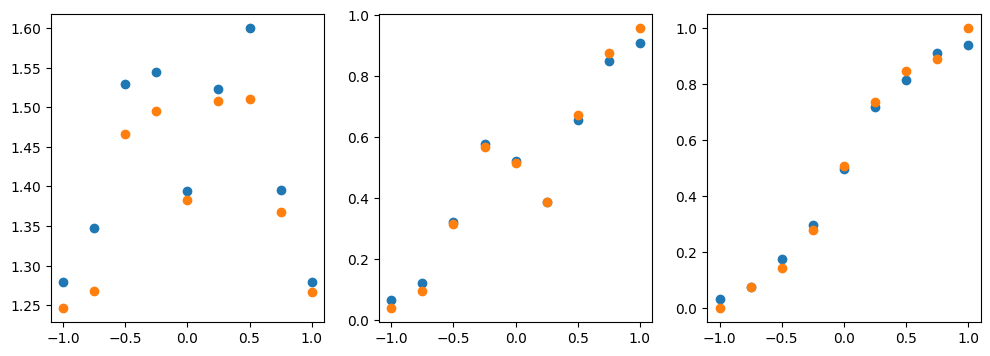

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

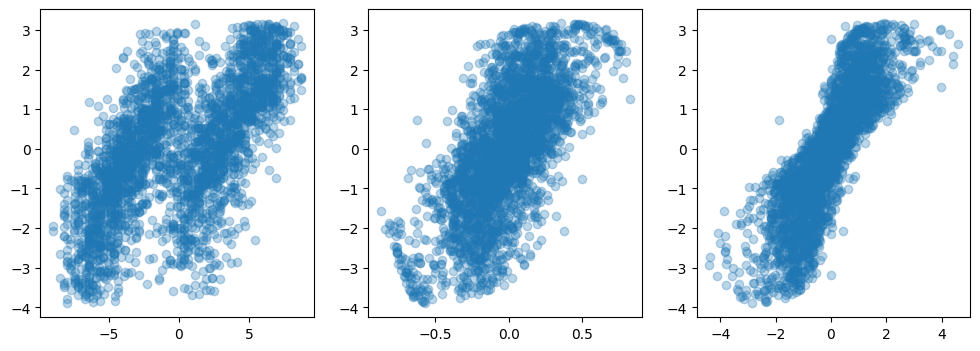

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

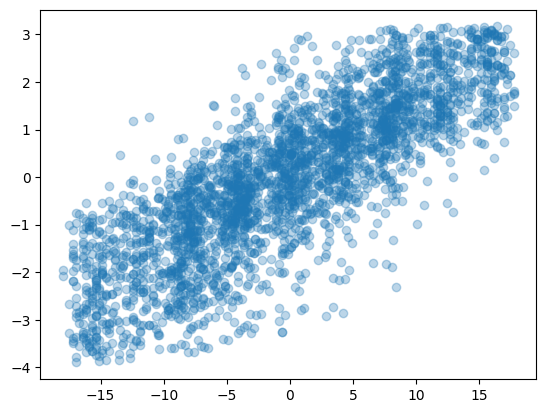

In [13]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);